In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Readme:

First, we 'll apply the techniques below for a single example image then we'll apply the same processes to all dataset images in order to find avg. RMSE and PSNR ratios.

# Configuration params

In [2]:
K = 3
single_img_path = "dataset/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_12.tif"
r_a, r_b = 0.1, 0.5

S
# Part 1) Stretch Image

In [3]:
def partial_contrast_stretching(image, lower_threshold, upper_threshold):
    normalized_image = image / 255.0
    
    stretched_image = np.piecewise(normalized_image,
                                   [normalized_image < lower_threshold,
                                    (normalized_image >= lower_threshold) & (normalized_image <= upper_threshold),
                                    normalized_image > upper_threshold],
                                   [lambda x: 0,
                                    lambda x: ((x - lower_threshold) / (upper_threshold - lower_threshold))**2,
                                    lambda x: 1])

    # Scale the stretched image back to the original intensity range
    stretched_image = (stretched_image * 255).astype(np.uint8)

    return stretched_image

In [4]:
original_image_3d = cv2.imread(single_img_path) 
original_image = cv2.imread(single_img_path, cv2.IMREAD_GRAYSCALE)

In [5]:
original_image = cv2.resize(original_image, (128,128))

In [6]:
stretched_image = partial_contrast_stretching(original_image, lower_threshold=0, upper_threshold=0.5)

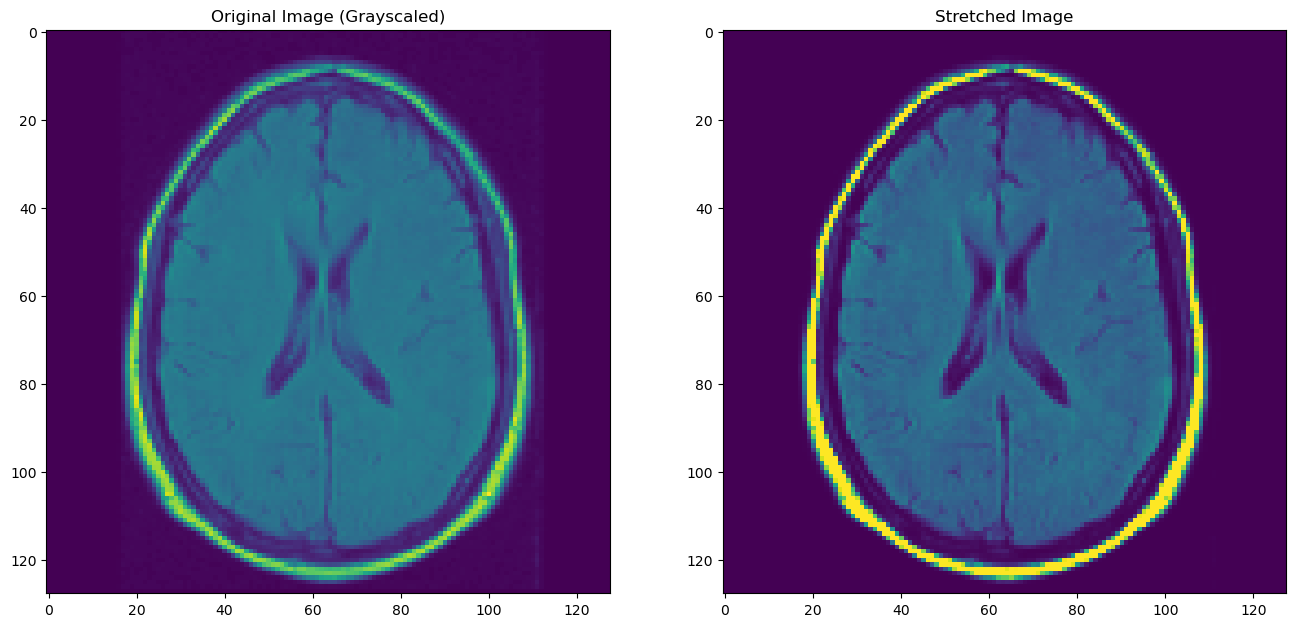

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))

ax1.set_title(f'Original Image (Grayscaled)')
ax1.imshow(original_image)
ax2.set_title(f'Stretched Image')
ax2.imshow(stretched_image)
plt.show()

# 2) Calculate potential of each pixel value

In [8]:
def progress(percent=0, width=50):
    left = width * percent // 100
    right = width - left

    tags = "#" * left
    spaces = " " * right
    percents = f"{percent:.0f}%"

    print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

def gaussian_kernel(x, Y, r):
    x = x /255.0 #normalize
    Y = Y /255.0
    return np.exp(-(np.abs(x - Y) ** 2) / (2 * r ** 2))

def find_k_potential_centers(X, num_clusters, threshold=0.1, r_a=1.0, r_b=0.5):
    num_points = len(X)
    grid_points = np.arange(num_points)
    potentials = np.zeros(num_points)
    cluster_centers = []
    # Calculate potential for each grid point using Gaussian distance
    for i in range(num_points):
        potentials[i] = np.sum(gaussian_kernel(X[i], X[:i], r_a))

    # Find grid point with maximum potential
    center = np.argmax(potentials)
    cluster_centers.append(center)
    
    while len(cluster_centers) < num_clusters:
        # Update potentials, reducing the potential of nearby grid points
        new_center = cluster_centers[-1]
        potential = potentials[new_center]
        
        for i in range(num_points):
            potentials[i] -= potential * gaussian_kernel(X[i], X[new_center], r_b)
        
        new_max_id = np.argmax(potentials)
        if new_max_id not in cluster_centers:
            cluster_centers.append(new_max_id)
        else:
            p = np.random.randint(0, num_points)
            cluster_centers.append(p)
            
        
    return cluster_centers[:num_clusters]  # Return only the first 'num_clusters' cluster centers
        
        
        

In [9]:
pot_centers = find_k_potential_centers(stretched_image.reshape(-1), num_clusters=K, threshold=0, r_a=0.2, r_b=0.2)

# 3) K means algorithm

In [10]:
def apply_clustering_segmentation(img, K, centers=None):
    # Flatten the image
    reshaped_img = img.reshape((-1, 1))
    cv2.setRNGSeed(42)
    
    # Define initial centers (you can provide your own initial centers)
    if not isinstance(centers, np.ndarray):
        # Fit KMeans with random centers
        kmeans = KMeans(n_clusters=K, init='random', n_init=1, algorithm='full')
    else:
        initial_centers = centers
        # Fit KMeans with initial centers
        kmeans = KMeans(n_clusters=K, init=initial_centers, n_init=1, algorithm='full')
    kmeans.fit(reshaped_img)
    
    # Get the labels and cluster centers
    label = kmeans.labels_
    center = kmeans.cluster_centers_
    
    # Convert back into uint8 and reshape to the original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(img.shape)
    return res2

# Apply another (Gaussian Mixture with same n_components = K value) clustering segmentation method to compare with proposed and default Kmeans algorithms

In [11]:
# Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=0)
gmm.fit(original_image.reshape((-1,1)))

# Get the labels and cluster centers
label = gmm.predict(original_image.reshape((-1,1)))
center = gmm.means_

# Convert back into uint8 and reshape to the original image shape
center = np.uint8(center)
res = center[label.flatten()]
segmented_img_gmm = res.reshape(original_image.shape)

# Plot results

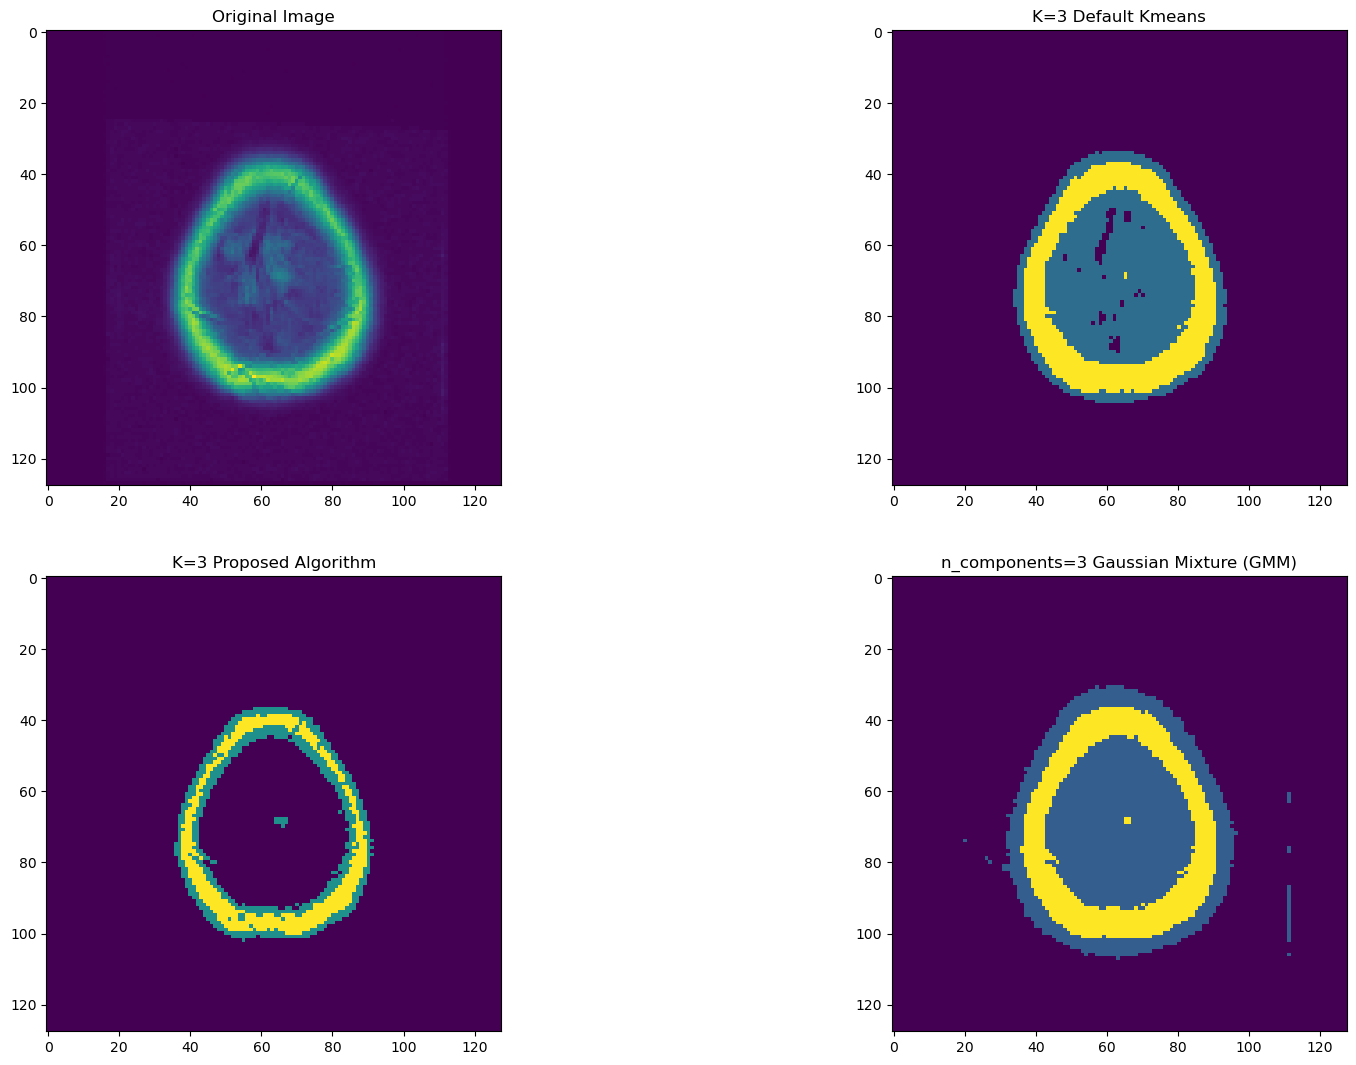

In [24]:
random_init_kMeans_segmented_img = apply_clustering_segmentation(original_image, K=K)
pot_init_kMeans_segmented_img = apply_clustering_segmentation(stretched_image, K=K, centers=np.array(pot_centers).reshape(-1, 1))

fig, axs = plt.subplots(2, 2, figsize=(20,13))

axs[0,0].set_title(f'Original Image')
axs[0,0].imshow(original_image)
axs[0,1].set_title(f'K={K} Default Kmeans')
axs[0,1].imshow(random_init_kMeans_segmented_img)
axs[1,0].set_title(f'K={K} Proposed Algorithm')
axs[1,0].imshow(pot_init_kMeans_segmented_img)
axs[1,1].set_title(f'n_components={K} Gaussian Mixture (GMM)')
axs[1,1].imshow(segmented_img_gmm)
plt.show()

# Calculate accuracies as said in paper (RMSE and PSNR values) for all algorithms

In [14]:
# Read the segmented image
proposed_algorithm_segmented_img = pot_init_kMeans_segmented_img
kmeans_segmented_img = random_init_kMeans_segmented_img

# Ensure both images have the same shape
if original_image.shape != proposed_algorithm_segmented_img.shape:
    raise ValueError("Original and segmented images must have the same shape")

if original_image.shape != kmeans_segmented_img.shape:
    raise ValueError("Original and segmented images must have the same shape")

if original_image.shape != segmented_img_gmm.shape:
    raise ValueError("Original and segmented images must have the same shape")

# Calculate RMSE
rmse_proposed_algo = np.sqrt(np.mean((original_image - proposed_algorithm_segmented_img) ** 2))
rmse_default_kmeans = np.sqrt(np.mean((original_image - kmeans_segmented_img) ** 2))
rmse_GMM = np.sqrt(np.mean((original_image - segmented_img_gmm) ** 2))
# Calculate PSNR
psnr_proposed_algo = cv2.PSNR(original_image, proposed_algorithm_segmented_img)
psnr_default_kmeans = cv2.PSNR(original_image, kmeans_segmented_img)
psnr_GMM = cv2.PSNR(original_image, segmented_img_gmm)

# Display the calculated measurements
print(f"""K value: {K}\n
------------------------
Proposed Algorithm Root Mean Square Error (RMSE): {rmse_proposed_algo}
Default Kmeans Algorithm Root Mean Square Error (RMSE): {rmse_default_kmeans}
Gaussian Mixture Algorithm Root Mean Square Error (RMSE): {rmse_GMM}
------------------------

Proposed Algorithm Peak Signal-to-Noise Ratio (PSNR): {psnr_proposed_algo} dB
Default Kmeans Algorithm Peak Signal-to-Noise Ratio (PSNR): {psnr_default_kmeans} dB
Gaussian Mixture Algorithm Peak Signal-to-Noise Ratio (PSNR): {psnr_GMM} dB
""")


K value: 3

------------------------
Proposed Algorithm Root Mean Square Error (RMSE): 7.677183594862035
Default Kmeans Algorithm Root Mean Square Error (RMSE): 6.317149046073909
Gaussian Mixture Algorithm Root Mean Square Error (RMSE): 8.003748968989079
------------------------

Proposed Algorithm Peak Signal-to-Noise Ratio (PSNR): 20.39761346143635 dB
Default Kmeans Algorithm Peak Signal-to-Noise Ratio (PSNR): 27.815451735526878 dB
Gaussian Mixture Algorithm Peak Signal-to-Noise Ratio (PSNR): 23.309923280429583 dB


# calculate RMSE and PSNR for whole dataset (https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) (MRI Segmentation Dataset was used) for all three algorithms

In [15]:
RMSEs_proposed_algo = []
RMSEs_default_Kmeans = []
RMSEs_GMM = []
PSNRs_proposed_algo = []
PSNRs_default_Kmeans = []
PSNRs_GMM = []

import os
for img_path in os.listdir("dataset/TCGA_CS_6290_20000917"):
    original_image = cv2.imread("dataset/TCGA_CS_6290_20000917/"+img_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (128,128))
    stretched_image = partial_contrast_stretching(original_image, lower_threshold=0, upper_threshold=1.0)
    pot_centers = find_k_potential_centers(stretched_image.reshape(-1), num_clusters=K, threshold=0, r_a=r_a, r_b=r_b)

    # Apply Gaussian Mixture Model clustering
    gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=0)
    gmm.fit(original_image.reshape((-1,1)))
    
    # Get the labels and cluster centers
    label = gmm.predict(original_image.reshape((-1,1)))
    center = gmm.means_
    
    # Convert back into uint8 and reshape to the original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_img_gmm = res.reshape(original_image.shape)

    random_init_kMeans_segmented_img = apply_clustering_segmentation(original_image, K=K)
    pot_init_kMeans_segmented_img = apply_clustering_segmentation(stretched_image, K=K, centers=np.array(pot_centers).reshape(-1, 1))
    # Read the segmented image
    proposed_algorithm_segmented_img = pot_init_kMeans_segmented_img
    kmeans_segmented_img = random_init_kMeans_segmented_img
    
    # Ensure both images have the same shape
    if original_image.shape != proposed_algorithm_segmented_img.shape:
        raise ValueError("Original and segmented images must have the same shape")
    
    if original_image.shape != kmeans_segmented_img.shape:
        raise ValueError("Original and segmented images must have the same shape")
    
    if original_image.shape != segmented_img_gmm.shape:
        raise ValueError("Original and segmented images must have the same shape")
    
    # Calculate RMSE
    rmse_proposed_algo = np.sqrt(np.mean((original_image - proposed_algorithm_segmented_img) ** 2))
    rmse_default_kmeans = np.sqrt(np.mean((original_image - kmeans_segmented_img) ** 2))
    rmse_GMM = np.sqrt(np.mean((original_image - segmented_img_gmm) ** 2))
    # Calculate PSNR
    psnr_proposed_algo = cv2.PSNR(original_image, proposed_algorithm_segmented_img)
    psnr_default_kmeans = cv2.PSNR(original_image, kmeans_segmented_img)
    psnr_GMM = cv2.PSNR(original_image, segmented_img_gmm)
    
    RMSEs_GMM.append(rmse_GMM)
    RMSEs_default_Kmeans.append(rmse_default_kmeans)
    RMSEs_proposed_algo.append(rmse_proposed_algo)
    
    PSNRs_GMM.append(psnr_GMM)
    PSNRs_default_Kmeans.append(psnr_default_kmeans)
    PSNRs_proposed_algo.append(psnr_proposed_algo)

In [16]:
np.array(RMSEs_GMM).mean(), np.array(RMSEs_default_Kmeans).mean(), np.array(RMSEs_proposed_algo).mean()

(6.6308014398550155, 6.1941737940225305, 7.875432736798895)

In [17]:
np.array(PSNRs_GMM).mean(), np.array(PSNRs_default_Kmeans).mean(), np.array(PSNRs_proposed_algo).mean()

(25.60108192399544, 27.911376511993353, 18.209668910346558)

In [ ]:
S